In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import rebound
import reboundx
import time
from ctypes import cdll
from scipy.integrate import quad
from scipy.special import gamma, spence
from scipy.optimize import minimize_scalar
from numba import jit
import scipy.odr as odr
from Burkert_profile_functions import *
from NFW_profile_functions import *
from Sersic_profile_functions import *
import os
import shutil

# matplotlib setup
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.facecolor'] = 'white'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif',size=15)
plt.rc('axes', linewidth=1.5)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15, direction='in')
plt.rc('ytick', labelsize=15, direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('xtick.minor', visible=True)
plt.rc('ytick.minor', visible=True)
plt.rc('xtick.major',size=10, pad=4)
plt.rc('xtick.minor',size=5, pad=4)
plt.rc('ytick.major',size=10)
plt.rc('ytick.minor',size=5)
plt.rc('legend', fontsize=15)

# masses of the GCs from the Georgiev catalogue in units of 1e5 solar masses
UGC7369_masses = np.array([ 0.5270876 ,  0.15333488,  1.08466861,  0.23894274,  0.53477108,
        0.66067185,  2.74824974, 43.7230426 ,  0.25702028,  0.68325756,
        0.48945594,  0.78176033,  0.98889862,  0.70596634,  1.74467125,
        1.42423357,  1.17664156,  0.49028781,  0.71836984,  0.42620355,
        0.33863009])
# total mass in GCs
UGC7369_total_mass = sum(UGC7369_masses)
UGC8638_total_mass = 31.8 
NGC4605_total_mass = 14.33
# UGC 7369 effective (half-light) radius in kpc
#UGC7369_R_e = 0.90
# projected separation divided by effective radius from Georgiev
#UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667,
      # 0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
       #1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
       #0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
       #1.22266667])
# physical projected radii
#UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e

# a C implementation of friction and background forces in rebound, for speed
clib_additional_forces = cdll.LoadLibrary("/home/vk9342/USRP2023/additional_forces.so")

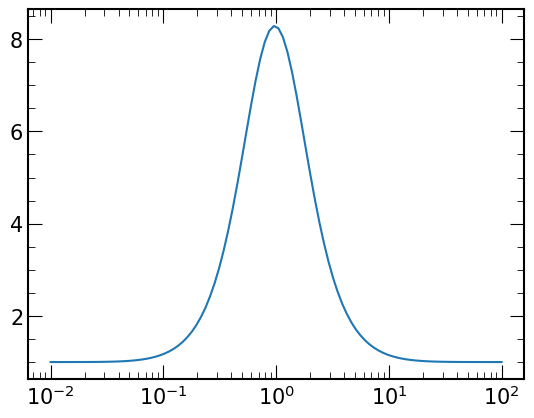

In [2]:
# mass function: gaussian in logM, mean/variance taken from Georgiev catalogue normal dist fit
def mass_function(logmass):
    # currently using a NSC cut fit
    mean = 4.987311450993631 - 5
    variance = 0.18871641457327373
    return 1/np.sqrt(2*np.pi*variance) * np.exp(-(logmass-mean)**2 / (2*variance))

# testing it out with a plot of the mass function
test_masses = np.logspace(-2, 2, 100)
plt.plot(test_masses, 10**mass_function(np.log10(test_masses)))
plt.xscale('log')
plt.show()

# custom merge function
def merge_energy(sim_pointer, collided_particles_index):
    sim = sim_pointer.contents
    ps = sim.particles
    
    i = collided_particles_index.p1
    j = collided_particles_index.p2
    
    # calculating the relevant energy to see if a merger really should happen or not
    dp = ps[i]-ps[j]
    total_mass = ps[i].m + ps[j].m
    reduced_mass = (ps[i].m*ps[j].m)/total_mass
    r_12 = np.sqrt(dp.x**2 + dp.y**2 + dp.z**2)
    v_12sq = dp.vx**2 + dp.vy**2 + dp.vz**2
    U_12 = -sim.G*ps[i].m*ps[j].m / (r_12**2.11 + (1.7*sim.softening)**2.11)**(1/2.11)
    E_12 = 0.5*reduced_mass*v_12sq + U_12
    #print('merge function called')
    if E_12 < 0:
        # if clusters did meet the energy condition, delete particle j and update particle i to the merged one
        #print(np.sqrt(ps[i].x**2 + ps[i].y**2 + ps[i].z**2), dp.vx, dp.vy, dp.vz)
        old_radius = ps[i].r
        new_particle = (ps[i]*ps[i].m + ps[j]*ps[j].m)/total_mass
        ps[i] = new_particle
        ps[i].m = total_mass
        ps[i].r = 2*2.548e-3*(total_mass/0.1)**(0.242)
        return 2
    else:
        # in case the clusters did pass near each other, but didn't meet the energy condition, do nothing
        return 0

Calculating NFW Energies and Weights


<ipython-input-3-bb09e961310f>:27: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]


Finished calculating NFW Energies and Weights
4.85997200012207
0.7 0.1


<ipython-input-3-bb09e961310f>:41: RuntimeWarning: divide by zero encountered in log10
  return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))
<ipython-input-3-bb09e961310f>:41: RuntimeWarning: divide by zero encountered in log10
  return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))


finished until t = 0.0 0.789703369140625


/home/vk9342/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 0.5 4.476348400115967
finished until t = 1.0 9.724214553833008
finished until t = 1.5 15.960127830505371
finished until t = 2.0 23.239886045455933
finished until t = 2.5 31.007594108581543
finished until t = 3.0 39.969207763671875
finished until t = 3.5 49.49060297012329
finished until t = 4.0 60.123804330825806
finished until t = 4.5 71.54158091545105
finished until t = 5.0 83.58581161499023
finished until t = 5.5 96.40960192680359
finished until t = 6.0 110.31182050704956
finished until t = 6.5 125.01161599159241
finished until t = 7.0 140.550457239151
finished until t = 7.5 157.05521965026855
finished until t = 8.0 174.31516313552856
finished until t = 8.5 192.47619700431824
finished until t = 9.0 211.6359145641327
finished until t = 9.5 231.60058188438416
finished until t = 10.0 252.16788291931152


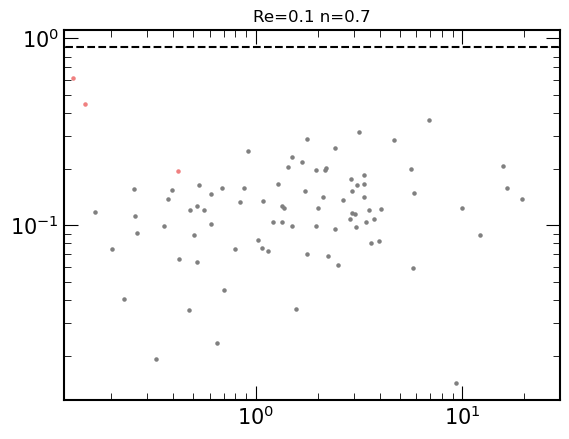

Calculating NFW Energies and Weights


<ipython-input-3-bb09e961310f>:27: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]


Finished calculating NFW Energies and Weights
4.528064489364624
0.7 0.3
finished until t = 0.0 0.45168042182922363
finished until t = 0.5 4.046650171279907
finished until t = 1.0 10.697504997253418
finished until t = 1.5 20.696550607681274
finished until t = 2.0 33.04476714134216
finished until t = 2.5 47.11864709854126
finished until t = 3.0 62.91593098640442
finished until t = 3.5 80.30018711090088
finished until t = 4.0 98.86971759796143
finished until t = 4.5 118.97849917411804
finished until t = 5.0 139.97597742080688
finished until t = 5.5 162.78361225128174
finished until t = 6.0 186.7338547706604
finished until t = 6.5 211.915673494339
finished until t = 7.0 237.8329610824585
finished until t = 7.5 265.014386177063
finished until t = 8.0 293.1686701774597
finished until t = 8.5 322.1372067928314
finished until t = 9.0 352.1847188472748
finished until t = 9.5 383.11357593536377
finished until t = 10.0 415.12826704978943


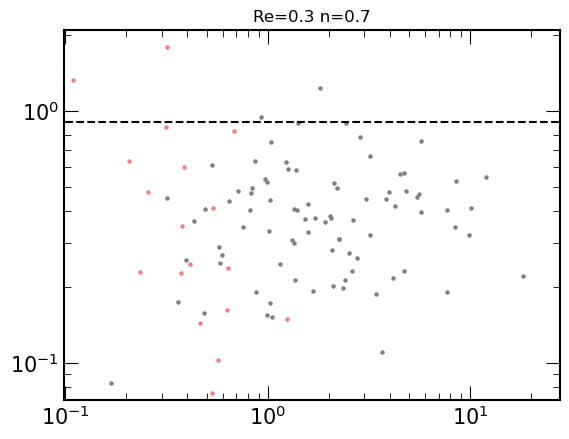

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
5.449258327484131
0.7 0.5
finished until t = 0.0 0.47254157066345215
finished until t = 0.5 4.137541055679321
finished until t = 1.0 11.251535892486572
finished until t = 1.5 22.105772256851196
finished until t = 2.0 36.23221802711487
finished until t = 2.5 54.104472637176514
finished until t = 3.0 75.66080069541931
finished until t = 3.5 100.56571221351624
finished until t = 4.0 128.29855942726135
finished until t = 4.5 158.17275476455688
finished until t = 5.0 191.50039291381836
finished until t = 5.5 227.18709993362427
finished until t = 6.0 265.7506387233734
finished until t = 6.5 307.136385679245
finished until t = 7.0 350.6053147315979
finished until t = 7.5 396.2371726036072
finished until t = 8.0 443.8521285057068
finished until t = 8.5 494.3191785812378
finished until t = 9.0 545.7648284435272
finished until t = 9.5 598.6797654628754
finished until t = 10.0 653.4629192352295


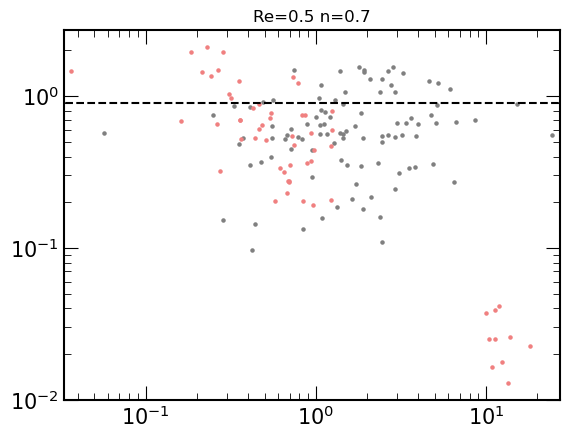

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
5.858755350112915
0.7 0.7
finished until t = 0.0 0.4276423454284668
finished until t = 0.5 3.4811768531799316
finished until t = 1.0 9.449187278747559
finished until t = 1.5 18.28115940093994
finished until t = 2.0 30.296494245529175
finished until t = 2.5 45.26763844490051
finished until t = 3.0 63.339680433273315
finished until t = 3.5 84.52941799163818
finished until t = 4.0 108.8711142539978
finished until t = 4.5 135.86149954795837
finished until t = 5.0 165.8784146308899
finished until t = 5.5 198.45775270462036
finished until t = 6.0 233.57780957221985
finished until t = 6.5 272.16943359375
finished until t = 7.0 313.0841016769409
finished until t = 7.5 357.3475878238678
finished until t = 8.0 404.140221118927
finished until t = 8.5 454.019376039505
finished until t = 9.0 505.7318744659424
finished until t = 9.5 560.0448253154755
finished until t = 10.0 616.4161758422852


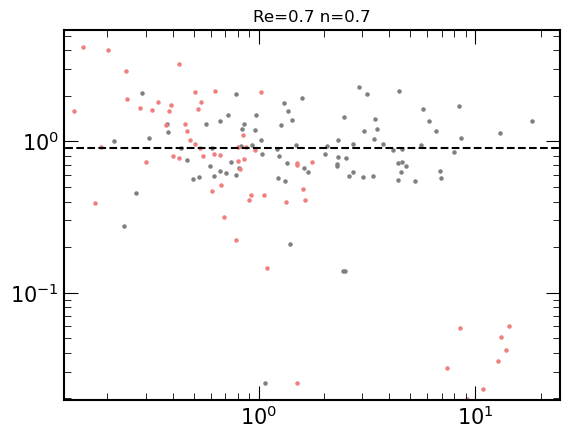

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
6.061906576156616
0.7 0.9
finished until t = 0.0 0.4731099605560303
finished until t = 0.5 3.884605646133423
finished until t = 1.0 9.58718729019165
finished until t = 1.5 18.44371747970581
finished until t = 2.0 29.489733934402466
finished until t = 2.5 43.687203884124756
finished until t = 3.0 60.59495997428894
finished until t = 3.5 80.15761494636536
finished until t = 4.0 102.86121225357056
finished until t = 4.5 128.4257092475891
finished until t = 5.0 157.87925744056702
finished until t = 5.5 190.0876383781433
finished until t = 6.0 225.49294424057007
finished until t = 6.5 264.7635142803192
finished until t = 7.0 308.07074213027954
finished until t = 7.5 354.3594391345978
finished until t = 8.0 404.5124001502991
finished until t = 8.5 461.829882144928
finished until t = 9.0 526.2441744804382
finished until t = 9.5 597.5998387336731
finished until t = 10.0 677.8703193664551


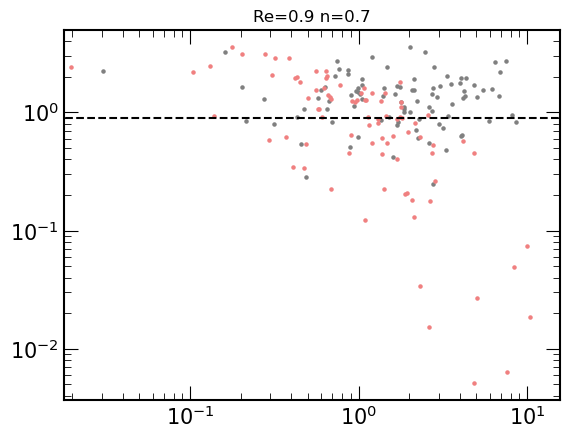

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.315071105957031
0.7 1.1
finished until t = 0.0 0.5162475109100342
finished until t = 0.5 3.6916844844818115
finished until t = 1.0 9.51551866531372
finished until t = 1.5 19.070753574371338
finished until t = 2.0 31.275815725326538
finished until t = 2.5 46.18575310707092
finished until t = 3.0 64.39124393463135
finished until t = 3.5 86.11602139472961
finished until t = 4.0 110.38180661201477
finished until t = 4.5 138.22875785827637
finished until t = 5.0 169.20229053497314
finished until t = 5.5 203.89242506027222
finished until t = 6.0 241.5888547897339
finished until t = 6.5 282.4000680446625
finished until t = 7.0 326.78451204299927
finished until t = 7.5 374.2166907787323
finished until t = 8.0 425.0740656852722
finished until t = 8.5 479.39455699920654
finished until t = 9.0 537.2861764431
finished until t = 9.5 598.0102202892303
finished until t = 10.0 662.2092931270599


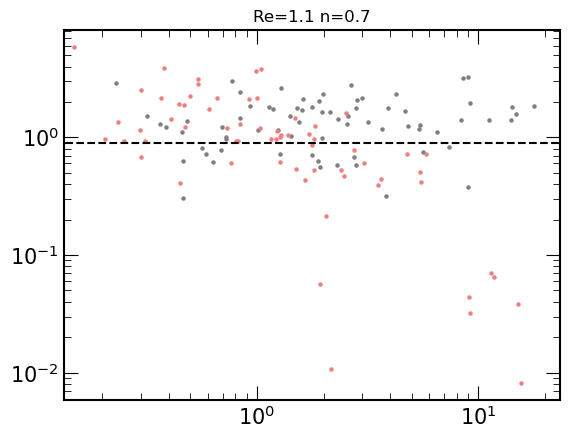

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.158759355545044
0.7 1.3
finished until t = 0.0 0.6145570278167725
finished until t = 0.5 4.734972238540649
finished until t = 1.0 11.70801067352295
finished until t = 1.5 22.527539014816284
finished until t = 2.0 36.31979250907898
finished until t = 2.5 53.568740129470825
finished until t = 3.0 74.25780940055847
finished until t = 3.5 98.44645738601685
finished until t = 4.0 126.62375974655151
finished until t = 4.5 158.2525293827057
finished until t = 5.0 193.32549619674683
finished until t = 5.5 232.05675148963928
finished until t = 6.0 274.05315709114075
finished until t = 6.5 319.9206461906433
finished until t = 7.0 369.33663272857666
finished until t = 7.5 423.2510771751404
finished until t = 8.0 479.84318256378174
finished until t = 8.5 540.6397140026093
finished until t = 9.0 604.617894411087
finished until t = 9.5 672.6536803245544
finished until t = 10.0 744.964026927948


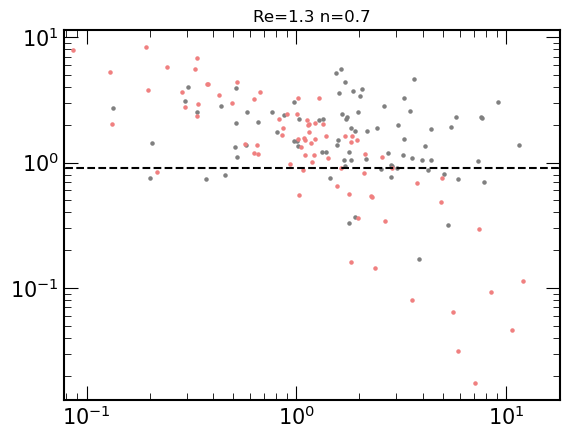

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.489259243011475
0.7 1.5
finished until t = 0.0 0.6720719337463379
finished until t = 0.5 5.492440223693848
finished until t = 1.0 14.559897184371948
finished until t = 1.5 27.000486850738525
finished until t = 2.0 43.18396615982056
finished until t = 2.5 63.45044708251953
finished until t = 3.0 87.26251077651978
finished until t = 3.5 115.60848546028137
finished until t = 4.0 148.2610263824463
finished until t = 4.5 184.36457800865173
finished until t = 5.0 224.96913480758667
finished until t = 5.5 269.9566421508789
finished until t = 6.0 319.263854265213
finished until t = 6.5 372.3847236633301
finished until t = 7.0 429.9940745830536
finished until t = 7.5 491.7954156398773
finished until t = 8.0 558.1939651966095
finished until t = 8.5 630.0091700553894
finished until t = 9.0 706.3152861595154
finished until t = 9.5 786.806967496872
finished until t = 10.0 873.4106080532074


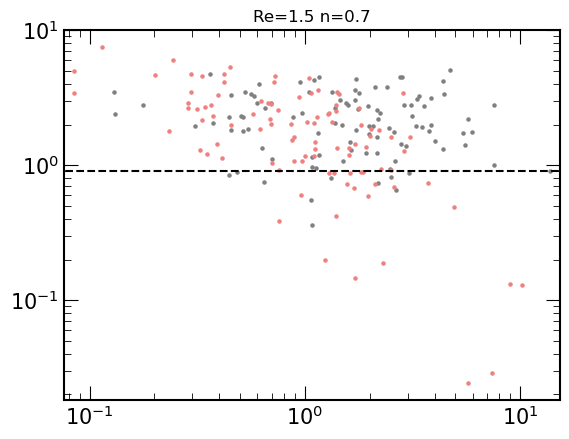

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.213399887084961
0.7 1.7
finished until t = 0.0 0.7485570907592773
finished until t = 0.5 6.204166650772095
finished until t = 1.0 15.797951459884644
finished until t = 1.5 30.117307662963867
finished until t = 2.0 48.341585874557495
finished until t = 2.5 71.50226545333862
finished until t = 3.0 99.69863152503967
finished until t = 3.5 132.4765179157257
finished until t = 4.0 171.01340889930725
finished until t = 4.5 212.15263533592224
finished until t = 5.0 258.39125394821167
finished until t = 5.5 309.0666334629059
finished until t = 6.0 364.5009479522705
finished until t = 6.5 425.0707206726074
finished until t = 7.0 490.2080521583557
finished until t = 7.5 559.8443558216095
finished until t = 8.0 633.957109451294
finished until t = 8.5 713.2612645626068
finished until t = 9.0 793.7896182537079
finished until t = 9.5 878.0581240653992
finished until t = 10.0 967.2160682678223


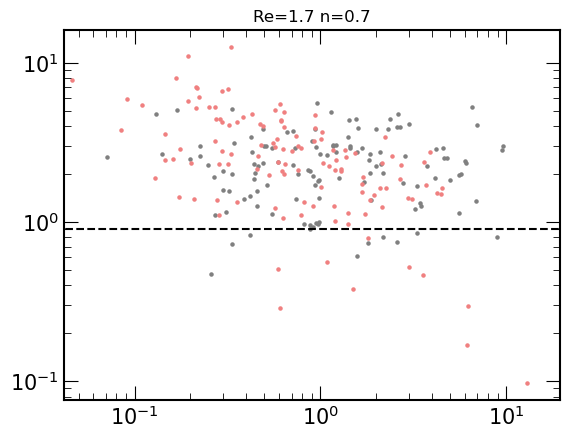

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.066879749298096
0.7 1.9
finished until t = 0.0 0.6194581985473633
finished until t = 0.5 4.708049058914185
finished until t = 1.0 12.302681684494019
finished until t = 1.5 23.424546718597412
finished until t = 2.0 38.10157132148743
finished until t = 2.5 55.73762059211731
finished until t = 3.0 76.71494579315186
finished until t = 3.5 100.93285083770752
finished until t = 4.0 128.5076310634613
finished until t = 4.5 159.6894862651825
finished until t = 5.0 193.70945858955383
finished until t = 5.5 231.50478291511536
finished until t = 6.0 272.0860478878021
finished until t = 6.5 315.99351358413696
finished until t = 7.0 363.8167691230774
finished until t = 7.5 414.34485054016113
finished until t = 8.0 468.7843577861786
finished until t = 8.5 526.1339719295502
finished until t = 9.0 588.4397466182709
finished until t = 9.5 653.3014028072357
finished until t = 10.0 720.2121541500092


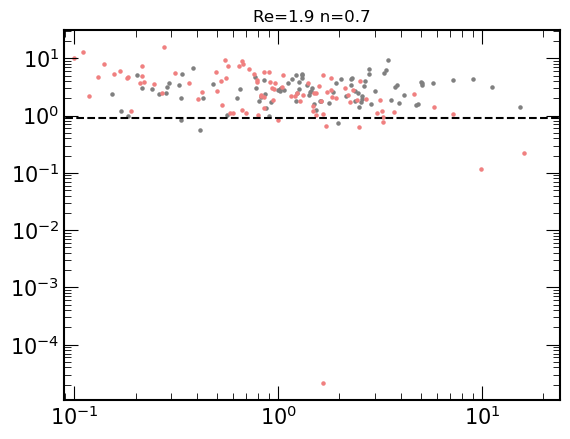

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.086593627929688
0.7 2.1
finished until t = 0.0 0.6448602676391602
finished until t = 0.5 4.795726776123047
finished until t = 1.0 12.484992742538452
finished until t = 1.5 23.627317428588867
finished until t = 2.0 38.29062819480896
finished until t = 2.5 56.50715351104736
finished until t = 3.0 80.31397771835327
finished until t = 3.5 107.51750707626343
finished until t = 4.0 137.0967993736267
finished until t = 4.5 170.39944863319397
finished until t = 5.0 210.70104026794434
finished until t = 5.5 252.7905433177948
finished until t = 6.0 296.94837284088135
finished until t = 6.5 345.08383893966675
finished until t = 7.0 398.4537932872772
finished until t = 7.5 455.6842465400696
finished until t = 8.0 514.8931334018707
finished until t = 8.5 577.6358470916748
finished until t = 9.0 644.2184772491455
finished until t = 9.5 714.2006747722626
finished until t = 10.0 788.1486916542053


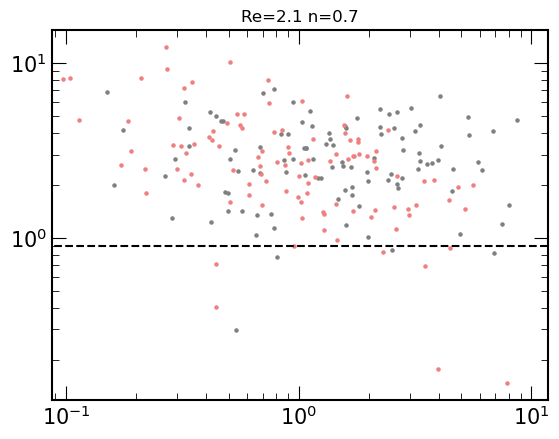

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.862848043441772
0.7 2.3
finished until t = 0.0 0.6331138610839844
finished until t = 0.5 4.340089797973633
finished until t = 1.0 11.206771612167358
finished until t = 1.5 21.197346687316895
finished until t = 2.0 34.35727405548096
finished until t = 2.5 50.67111015319824
finished until t = 3.0 70.0683946609497
finished until t = 3.5 92.60120606422424
finished until t = 4.0 118.34397339820862
finished until t = 4.5 147.24590373039246
finished until t = 5.0 179.2746958732605
finished until t = 5.5 214.46780610084534
finished until t = 6.0 252.85516905784607
finished until t = 6.5 294.3826596736908
finished until t = 7.0 339.28354930877686
finished until t = 7.5 387.3076949119568
finished until t = 8.0 438.51006603240967
finished until t = 8.5 493.16612792015076
finished until t = 9.0 551.6002857685089
finished until t = 9.5 614.4653866291046
finished until t = 10.0 679.6457588672638


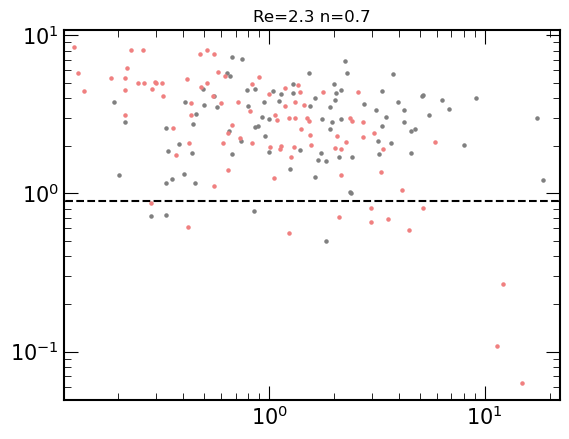

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.89717698097229
0.7 2.5
finished until t = 0.0 0.6926712989807129
finished until t = 0.5 5.126704931259155
finished until t = 1.0 13.350116729736328
finished until t = 1.5 25.307337760925293
finished until t = 2.0 41.09920811653137
finished until t = 2.5 60.56363272666931
finished until t = 3.0 83.79953980445862
finished until t = 3.5 110.71025729179382
finished until t = 4.0 141.52151226997375
finished until t = 4.5 176.03347396850586
finished until t = 5.0 214.14423441886902
finished until t = 5.5 255.399653673172
finished until t = 6.0 300.5451591014862
finished until t = 6.5 349.9291560649872
finished until t = 7.0 402.9032597541809
finished until t = 7.5 460.11772894859314
finished until t = 8.0 521.2217996120453
finished until t = 8.5 585.7646069526672
finished until t = 9.0 654.1941645145416
finished until t = 9.5 726.7962317466736
finished until t = 10.0 803.1228611469269


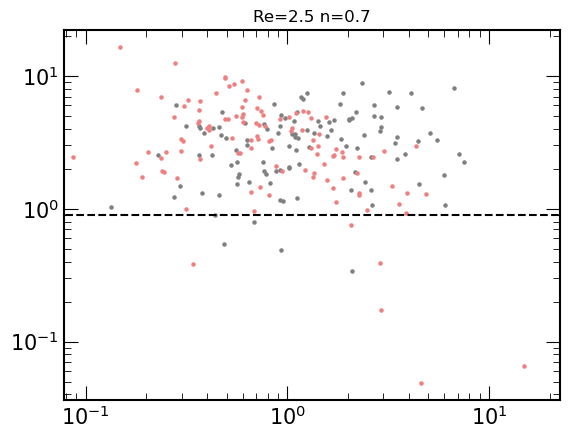

In [3]:
#NFW

n_values = [0.7]
R_e_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5]
1
for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        
        # NFW ergodic distribution function, calling helpers from NFW_profile_functions.py
        ######################################
        # MAKE SURE THESE rho_0 and r_0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
        ######################################

        rho_0_NFW = 17.99 # 10^5 solar masses / kpc^3
        r_0_NFW = 25.34 # kpc
        G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
        Sersic_params_NFW = [R_e, n]
        @np.vectorize
        def NFW_ergodic_f(E):
            def integrand(psi):
                def r_psi(psi):
                    rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho_0_NFW, r_0_NFW))  #lambda (def short function) arguments : expression
                    return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
                return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho_0_NFW, r_0_NFW, Sersic_params_NFW[0], Sersic_params_NFW[1])
            return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

        start = time.time()
        print('Calculating NFW Energies and Weights')
        energy_values_NFW = 4 * np.pi * G * rho_0_NFW * r_0_NFW**2 * np.arange(-1+0.005, -0.005, 0.005)
        energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
        #E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
        print('Finished calculating NFW Energies and Weights')
        print(time.time()-start)
        print(n, R_e)

        #making interpolated functions for f(E) that can be called in the initialization process for speed

        def NFW_f_interp(E):
            return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))
        
    
        #################################
        ## SAVES OUTPUTS FOR EVERY 0.5 Gyr

        def run_sim(potential, force, halo_params, ergodic_f, seed, t):
            start = time.time()
            np.random.seed(seed)

            # usual initialization of the sim, units, etc.
            sim = rebound.Simulation()
            sim.ri_ias15.epsilon = 0 # using fixed timesteps
            #sim.ri_ias15.min_dt = 1e-5
            #sim.ri_ias15.max_dt = 1e-3
            sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
            sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
            sim.softening = 0.01 # plummer softening of 10 pc
            sim.collision = "line" # counting collisions as linear interpolations between timesteps
            sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers

            # Sersic radial distribution and values to draw positions with their weights

            pos_values = np.arange(1e-4, 10, 1e-4)
            pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
            pos_weights /= sum(pos_weights)

            # unpacking halo params
            rho_0 = halo_params[0]
            r_0 = halo_params[1]

            # setting up a mass function gaussian in logM
            logmass_values = np.linspace(-2, 2, 1000)
            logmass_weights = mass_function(logmass_values)
            logmass_weights /= sum(logmass_weights)

            total_GC_mass = 0
            # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
            while total_GC_mass < NGC4605_total_mass-10**(4.987311450993631 - 5):
                mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
                pos_rad = np.random.choice(pos_values, p=pos_weights)
                pos_theta = np.random.uniform(0, np.pi)
                pos_phi = np.random.uniform(0, 2*np.pi)
                x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
                y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
                z_i = pos_rad*np.cos(pos_theta)

                # drawing velocities from provided distribution
                vel_values = np.arange(0.01, 100, 0.01)
                vel_weights = 4*np.pi*vel_values**2 * \
                                ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho_0, r_0))/(nu(pos_rad, R_e, n))
                vel_weights /= sum(vel_weights)
                vel_mag = np.random.choice(vel_values, p=vel_weights)
                v_theta = np.random.uniform(0, np.pi)
                v_phi = np.random.uniform(0, 2*np.pi)
                vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
                vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
                vz_i = vel_mag * np.cos(v_theta)

                sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                        x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
                total_GC_mass += mass/np.exp(10/23)

            rebx = reboundx.Extras(sim)
            # adding in the additional forces to work with reboundx
            myforce = rebx.create_force("additional_forces")
            myforce.force_type = "vel"
            myforce.update_accelerations = force
            rebx.add_force(myforce)
            # setting up built-in exponential mass loss
            modifymass = rebx.load_operator("modify_mass")
            rebx.add_operator(modifymass)
            # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
            for p in sim.particles:
                p.params["tau_mass"] = -23

            # keeping track of initial positions, velocities, and masses
            initial_masses = []
            initial_positions = []
            initial_vels = []

            for p in sim.particles:
                initial_masses.append(p.m)
                initial_positions.append(np.array([p.x, p.y, p.z]))
                initial_vels.append(np.array([p.vx, p.vy, p.vz]))

            # integrating
            sim.integrate(t)

            # keeping track of final positions, velocities, and masses
            final_masses = []
            final_positions = []
            final_vels = []

            for p in sim.particles:
                final_masses.append(p.m)
                final_positions.append(np.array([p.x, p.y, p.z]))
                final_vels.append(np.array([p.vx, p.vy, p.vz]))

            initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
            initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
            initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)

            # clearing sim from memory now that we've stored everything important
            sim = None

            # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
            return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]
        
        ###############################################################################
        ## run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs

        def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
            seeds = np.random.randint(1, 4294967295, size = N_iterations)

            start = time.time()

            for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):

                if output_time == 0:
                    # save initial data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=0.001)
                        for GC_n in range(len(masses[0])):
                            f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                                    +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                                    +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                                    +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                else:
                    # save final data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=t)
                        for GC_n in range(len(masses[1])):
                            f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                        +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                        +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                        +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                print('finished until t = '+str(t), str(time.time()-start))

        ##############################################
        #RUNS EVERYTHING 
        
        run_iterations(10, 'ZoomNFW-3', phi_NFW, clib_additional_forces.NFW_DF_Petts, [17.99, 25.34], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_ZoomNFW-3_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_ZoomNFW-3_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
        
        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        #plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('ZoomNFW-3_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()
        
             